# Taller 4

Integrantes:
* Oscar Javier Ángel Balcázar
* Rafael Camilo Tejon Rojas
* Juan Sebastian Alvarez Eraso

# Enunciado

El área de fidelización de una empresa de telecomunicaciones tiene como uno de sus objetivos disminuir la tasa de churn (abandono) por parte de sus clientes. Por esta razón, desea construir un modelo de machine learning que permita predecir si un cliente es propenso abandonar los servicios que actualmente tiene contratados con la empresa. Una vez construido, este modelo debe ser disponibilizado a través de una API REST que pueda ser consumida por la plataforma que es usada por los asesores de call center usando dicha predicción para ofrecer nuevos productos o servicios para los clientes más propensos al abandono.

**Diccionario de Datos **


|Field | Description|
|------|------------|
|customerID | Customer ID|
|gender | Whether the customer is a male or a female|
|SeniorCitizen | Whether the customer is a senior citizen or not (1, 0)|
|Partner | Whether the customer has a partner or not (Yes, No)|
|Dependents | Whether the customer has dependents or not (Yes, No)|
|tenure | Number of months the customer has stayed with the company|
|PhoneService | Whether the customer has a phone service or not (Yes, No)|
|MultipleLines | Whether the customer has multiple lines or not (Yes, No, No phone service)|
|InternetService | Customer’s internet service provider (DSL, Fiber optic, No)|
|OnlineSecurity | Whether the customer has online security or not (Yes, No, No internet service)|
|OnlineBackup | Whether the customer has online backup or not (Yes, No, No internet service)|
|DeviceProtection | Whether the customer has device protection or not (Yes, No, No internet service)|
|TechSupport | Whether the customer has tech support or not (Yes, No, No internet service)|
|StreamingTV | Whether the customer has streaming TV or not (Yes, No, No internet service)|
|StreamingMovies | Whether the customer has streaming movies or not (Yes, No, No internet service)|
|Contract | The contract term of the customer (Month-to-month, One year, Two year)|
|PaperlessBilling | Whether the customer has paperless billing or not (Yes, No)|
|PaymentMethod | The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))|
|MonthlyCharges | The amount charged to the customer monthly|
|TotalCharges | The total amount charged to the customer|
|Churn Whether | the customer churned or not (Yes or No)|

# Actividades

## Setup inicial

In [ ]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     / 22.0 MB 149 kB/s
     |████████████████████████████████| 102 kB 12.8 MB/s 
     |████████████████████████████████| 679 kB 4.3 MB/s 
     |████████████████████████████████| 62 kB 422 kB/s 
     |████████████████████████████████| 9.9 MB 14.2 MB/s 
     |████████████████████████████████| 4.7 MB 55.3 MB/s 
     |████████████████████████████████| 296 kB 18.7 MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-dev-py2.py3-none-any.whl size=324949 sha256=5d5960b839109e492752982f81dbf62a44832fb626bc2ff171125a7374a6bfc1
  Stored in directory: /tmp/pip-ephem-wheel-cache-48it4kqa/wheels/64/b6/85/dfc808b23666a5910371784e349d28818006ff63ed9cfeca59
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=bcea9558eb99d089dd09785903f8732c762188eb906bb1f5a4e8bc26886ee711
  Stored in directory: /root/.cache/pip/wheels/23/14/6e/4be5bfeeb027f4939a01764b

In [ ]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import warnings

from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression, SGDRegressor, LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer

# Configuración de pandas para extender el número de filas y columnas en la visualización
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# Deshabilitar warnings
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

## Limpieza y preparación de datos

In [ ]:
# Dataset No. 1
customers_df = pd.read_json('https://raw.githubusercontent.com/juanalvarez123/MINE-4101-taller-4/main/Datasets/DataSet_Entrenamiento_v1.json')
customers_df.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,5386-THSLQ,Female,1,Yes,No,66,No,No phone service,DSL,No,Yes,Yes,No,Yes,No,One year,No,Bank transfer (automatic),45.55,3027.25,No
4,3192-NQECA,Male,0,Yes,No,68,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),110.00,7611.85,Yes
5,6180-YBIQI,Male,0,No,No,5,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,No,Mailed check,24.30,100.2,No
6,6728-DKUCO,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,Yes,No,No,Yes,Yes,One year,Yes,Electronic check,104.15,7303.05,No
7,9750-BOOHV,Female,0,No,No,32,No,No phone service,DSL,Yes,No,No,No,No,No,One year,No,Mailed check,30.15,927.65,No
8,8597-CWYHH,Male,0,No,No,43,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,One year,No,Mailed check,94.35,3921.3,No
9,2848-YXSMW,Male,0,Yes,Yes,72,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),19.40,1363.25,No


In [ ]:
# Validación de nulos en cada una de las columnas del Dataframe.
customers_df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [ ]:
# Se transforma la columna TotalCharges a numérica y los datos que no pueden ser transformados se dejan nulos. 
customers_df["TotalCharges"] = pd.to_numeric(customers_df["TotalCharges"], errors='coerce')

In [ ]:
# Datos nullos de la columna TotalCharges
customers_df_temp = customers_df[customers_df['TotalCharges'].isna()]

customers_df_temp

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
288,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
553,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
736,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1040,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
2831,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3215,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
3669,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
4507,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
5859,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No
5943,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,NaN,No


Como el campo *`tenure`* se encuentra en 0 indica que a estos clientes la compañia no les ha facturado el primer mes por lo cual en la variable *`TotalCharges`* se asignará el valor de 0

In [ ]:
customers_df['TotalCharges'].fillna(0, inplace=True)

In [ ]:
ProfileReport(customers_df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Análisis exploratorio de datos

Porcentaje de churn total del data set.

In [ ]:
contract_churn_total = customers_df.groupby(['Churn']).agg({'customerID':['count']})
contract_churn_total = customers_df.groupby(['Churn']).agg({'customerID':['count']})
contract_churn_total.reset_index(inplace=True)
contract_churn_total.columns = ['Churn','Count']

contract_churn_total['percent'] = (contract_churn_total['Count']/customers_df['customerID'].count())*100

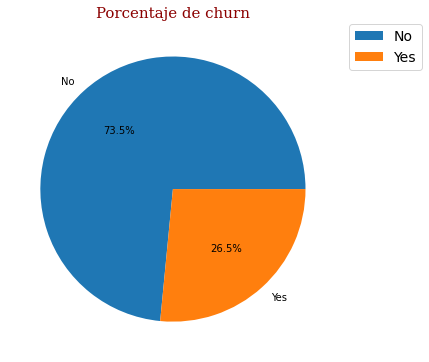

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(contract_churn_total['percent'], labels=contract_churn_total['Churn'], autopct='%.1f%%')
font = {'family':'serif','color':'darkred','size':15}
ax.set_title('Porcentaje de churn', font)
ax.legend(bbox_to_anchor=(1.01, 1.02), loc='upper left', fontsize=14)
plt.tick_params(labelsize=14)
plt.tight_layout()


De la anterior gráfica se puede concluir que el 73.5% de los clientes de la compañia no hacen churn y el 26.5% si abandonan la compañia.

Verificación del *churn* de acuerdo al tipo de contrato con la compañia 

In [ ]:
contract_churn = customers_df.groupby(['Contract','Churn']).agg({'customerID':['count']})
contract_churn = customers_df.groupby(['Contract','Churn']).agg({'customerID':['count']})
contract_churn.reset_index(inplace=True)
contract_churn.columns = ['Contract','Churn','Count']

contract_churn['percent'] = (contract_churn['Count']/customers_df['customerID'].count())*100

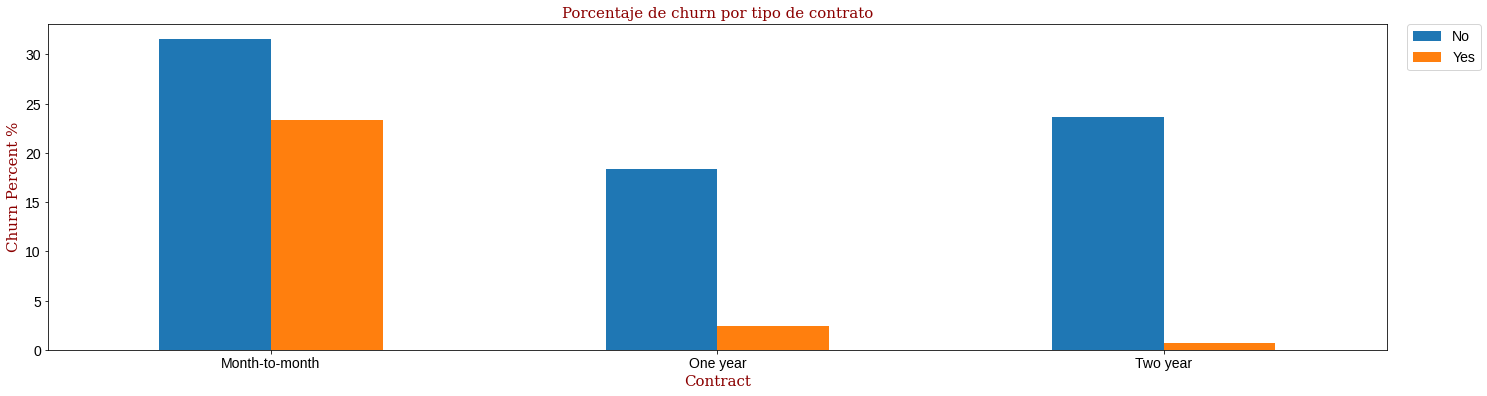

In [ ]:
# transform the shape
dfp = contract_churn.pivot(index='Contract', columns='Churn', values='percent')
dfp
# plot
ax = dfp.plot(kind='bar', rot=0, figsize=(24, 6))
font = {'family':'serif','color':'darkred','size':15}
plt.xlabel("Contract", font)
plt.ylabel("Churn Percent %", font)
plt.title("Porcentaje de churn por tipo de contrato", font)
ax.legend(bbox_to_anchor=(1.01, 1.02), loc='upper left', fontsize=14)
plt.style.use('seaborn')
plt.tick_params(labelsize=14)
plt.show()

De acuerdo a la anterior gráfica se puede observar que el menor porcentaje de *churn* se da en los contratos de uno o dos años, contrario a lo que sucede con el contrato mes a mes en el cual el porcentaje de churn es aproximadamente del 23% 

Verificación del *churn* de acuerdo al Genero

In [ ]:
contract_churn = customers_df.groupby(['gender','Churn']).agg({'customerID':['count']})
contract_churn = customers_df.groupby(['gender','Churn']).agg({'customerID':['count']})
contract_churn.reset_index(inplace=True)
contract_churn.columns = ['Gender','Churn','Count']

contract_churn['percent'] = (contract_churn['Count']/customers_df['customerID'].count())*100

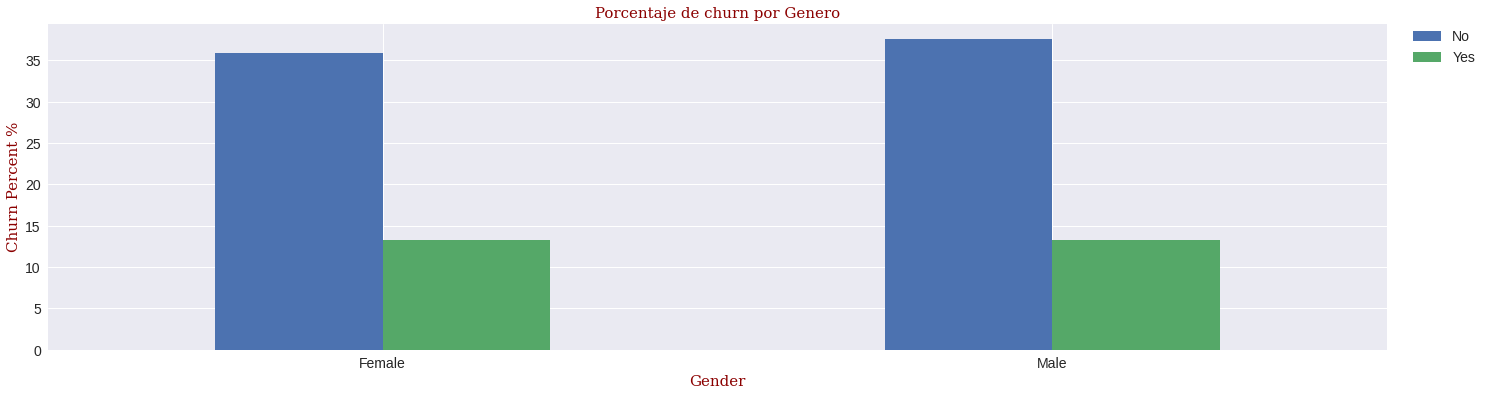

In [ ]:
# transform the shape
dfp = contract_churn.pivot(index='Gender', columns='Churn', values='percent')
dfp
# plot
ax = dfp.plot(kind='bar', rot=0, figsize=(24, 6))
font = {'family':'serif','color':'darkred','size':15}
plt.xlabel("Gender", font)
plt.ylabel("Churn Percent %", font)
plt.title("Porcentaje de churn por Genero", font)
ax.legend(bbox_to_anchor=(1.01, 1.02), loc='upper left', fontsize=14)
plt.style.use('seaborn')
plt.tick_params(labelsize=14)
plt.show()

De acuerdo a la anterior gráfica se puede observar que el churn en en los generos es similar y no existe una relación entre esta variable y el abandono de los servicios de la compañia

Número de churns & No churns por tipo de cliente

In [ ]:
contract_churn = customers_df.groupby(['SeniorCitizen','Churn']).agg({'customerID':['count']})
contract_churn.reset_index(inplace=True)
contract_churn.columns = ['SeniorCitizen','Churn','Count']

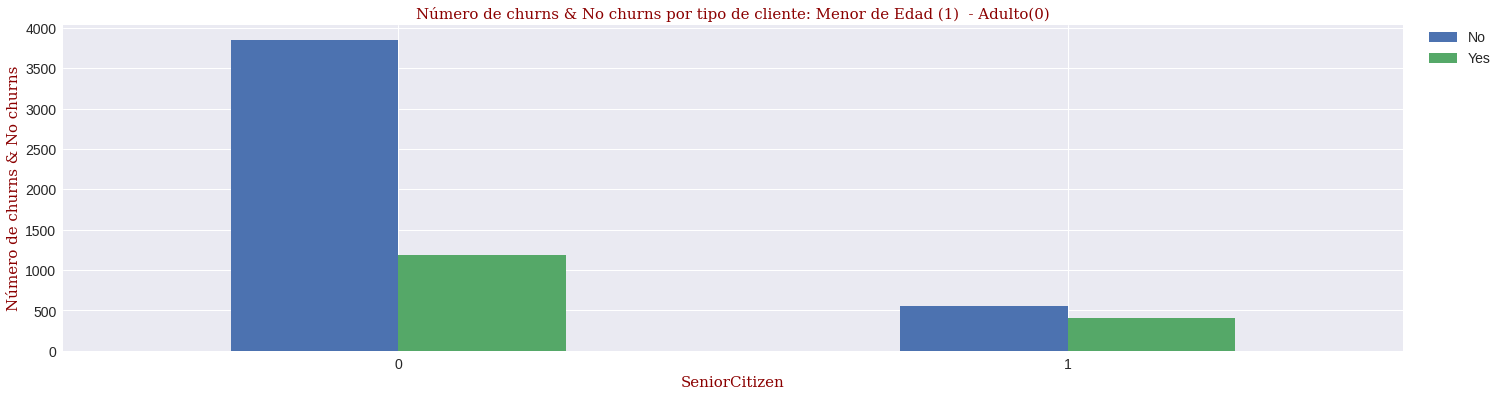

In [ ]:
# transform the shape
dfp = contract_churn.pivot(index='SeniorCitizen', columns='Churn', values='Count')
dfp
# plot
ax = dfp.plot(kind='bar', rot=0, figsize=(24, 6))
font = {'family':'serif','color':'darkred','size':15}
plt.xlabel("SeniorCitizen", font)
plt.ylabel("Número de churns & No churns", font)
plt.title("Número de churns & No churns por tipo de cliente: Menor de Edad (1)  - Adulto(0)", font)
ax.legend(bbox_to_anchor=(1.01, 1.02), loc='upper left', fontsize=14)
plt.style.use('seaborn')
plt.tick_params(labelsize=14)
plt.show()

De la anterior gráfica se puede concluir que la meyoria de clientes menores de edad abandonan la compañia, quizas no son los clientes más estables.


Churn por tipo de pago 

In [ ]:
payment_churn = customers_df.groupby(['PaymentMethod','Churn']).agg({'customerID':['count']})
payment_churn.reset_index(inplace=True)
payment_churn.columns = ['PaymentMethod','Churn','Count']

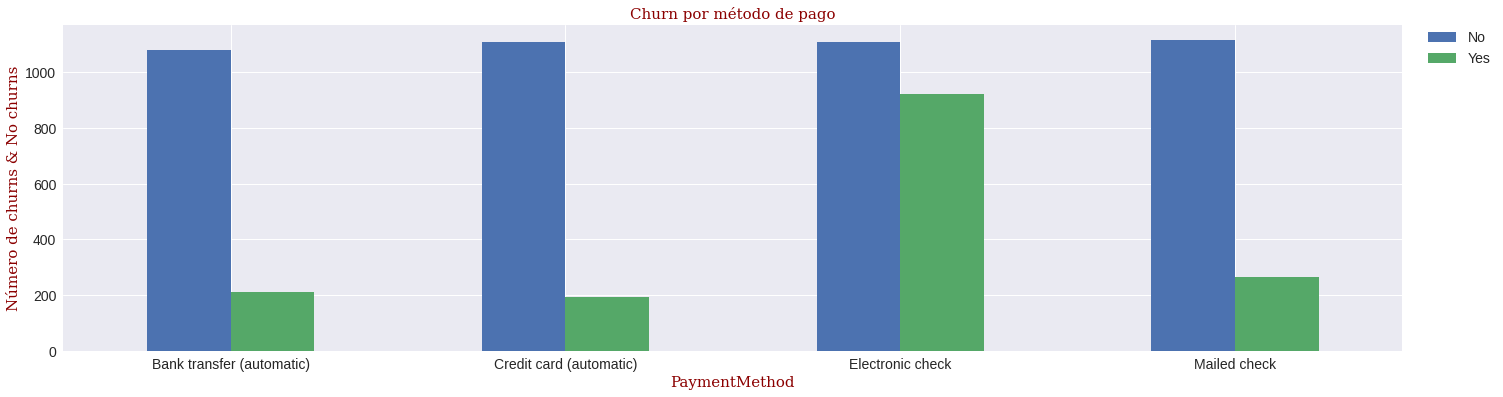

In [ ]:
# transform the shape
dfp = payment_churn.pivot(index='PaymentMethod', columns='Churn', values='Count')
dfp
# plot
ax = dfp.plot(kind='bar', rot=0, figsize=(24, 6))
font = {'family':'serif','color':'darkred','size':15}
plt.xlabel("PaymentMethod", font)
plt.ylabel("Número de churns & No churns", font)
plt.title("Churn por método de pago", font)
ax.legend(bbox_to_anchor=(1.01, 1.02), loc='upper left', fontsize=14)
plt.style.use('seaborn')
plt.tick_params(labelsize=14)
plt.show()

Validación del churn por servicio prestado

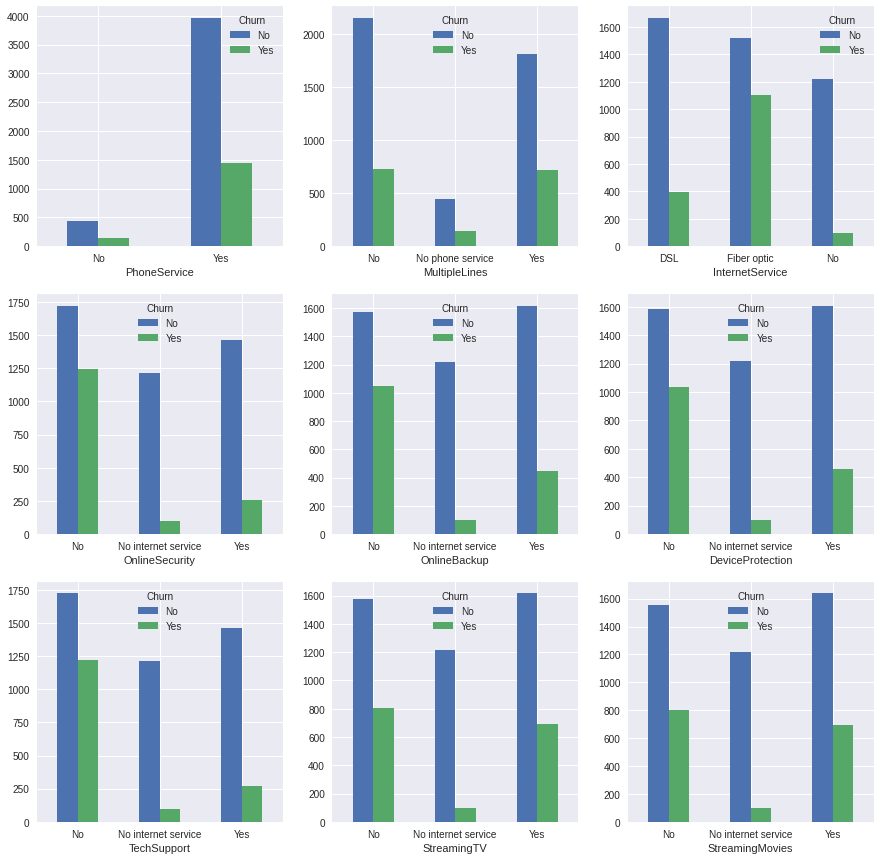

In [ ]:
# Se realizaron agrupamientos por cada una de las variables:
service_churn = customers_df[['customerID','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Churn']]

phone_service_churn = service_churn.groupby(['PhoneService','Churn']).agg({'customerID':['count']})
phone_service_churn.reset_index(inplace=True)
phone_service_churn.columns = ['PhoneService','Churn','Count']
phone_service_churn_dfp = phone_service_churn.pivot(index='PhoneService', columns='Churn', values='Count')

multiple_lines_churn = service_churn.groupby(['MultipleLines','Churn']).agg({'customerID':['count']})
multiple_lines_churn.reset_index(inplace=True)
multiple_lines_churn.columns = ['MultipleLines','Churn','Count']
multiple_lines_churn_dfp = multiple_lines_churn.pivot(index='MultipleLines', columns='Churn', values='Count')

internet_service_churn = service_churn.groupby(['InternetService','Churn']).agg({'customerID':['count']})
internet_service_churn.reset_index(inplace=True)
internet_service_churn.columns = ['InternetService','Churn','Count']
internet_service_churn_dfp = internet_service_churn.pivot(index='InternetService', columns='Churn', values='Count')

online_security_churn = service_churn.groupby(['OnlineSecurity','Churn']).agg({'customerID':['count']})
online_security_churn.reset_index(inplace=True)
online_security_churn.columns = ['OnlineSecurity','Churn','Count']
online_security_churn_dfp = online_security_churn.pivot(index='OnlineSecurity', columns='Churn', values='Count')

online_backup_churn = service_churn.groupby(['OnlineBackup','Churn']).agg({'customerID':['count']})
online_backup_churn.reset_index(inplace=True)
online_backup_churn.columns = ['OnlineBackup','Churn','Count']
online_backup_churn_dfp = online_backup_churn.pivot(index='OnlineBackup', columns='Churn', values='Count')

device_protection_churn = service_churn.groupby(['DeviceProtection','Churn']).agg({'customerID':['count']})
device_protection_churn.reset_index(inplace=True)
device_protection_churn.columns = ['DeviceProtection','Churn','Count']
device_protection_churn_dfp = device_protection_churn.pivot(index='DeviceProtection', columns='Churn', values='Count')

tech_support_churn = service_churn.groupby(['TechSupport','Churn']).agg({'customerID':['count']})
tech_support_churn.reset_index(inplace=True)
tech_support_churn.columns = ['TechSupport','Churn','Count']
tech_support_churn_dfp = tech_support_churn.pivot(index='TechSupport', columns='Churn', values='Count')

streaming_tv_churn = service_churn.groupby(['StreamingTV','Churn']).agg({'customerID':['count']})
streaming_tv_churn.reset_index(inplace=True)
streaming_tv_churn.columns = ['StreamingTV','Churn','Count']
streaming_tv_churn_dfp = streaming_tv_churn.pivot(index='StreamingTV', columns='Churn', values='Count')

streaming_movies = service_churn.groupby(['StreamingMovies','Churn']).agg({'customerID':['count']})
streaming_movies.reset_index(inplace=True)
streaming_movies.columns = ['StreamingMovies','Churn','Count']
streaming_movies_dfp = streaming_movies.pivot(index='StreamingMovies', columns='Churn', values='Count')

#Se define un subplots layout para agrupar las gráficas de todos los dataframe
fig, axes = plt.subplots(nrows=3, ncols=3, figsize = (15, 15))

#Se genera cada uno de las gráficas
phone_service_churn_dfp.plot(kind='bar', rot=0,ax=axes[0,0])
multiple_lines_churn_dfp.plot(kind='bar', rot=0,ax=axes[0,1])
internet_service_churn_dfp.plot(kind='bar', rot=0,ax=axes[0,2])
online_security_churn_dfp.plot(kind='bar', rot=0,ax=axes[1,0])

online_backup_churn_dfp.plot(kind='bar', rot=0,ax=axes[1,1])
device_protection_churn_dfp.plot(kind='bar', rot=0,ax=axes[1,2])
tech_support_churn_dfp.plot(kind='bar', rot=0,ax=axes[2,0])
streaming_tv_churn_dfp.plot(kind='bar', rot=0,ax=axes[2,1])
streaming_movies_dfp.plot(kind='bar', rot=0,ax=axes[2,2])
plt.show()

De los anteriores gráficos se pueden concluir:
- Los clientes que no tienen contratados los siguientes servicios tienen mayor probabilidad de hacer churn: OnlineSecurity, OnlineBackup, DeviceProtection, TechSuppor.

- El churn en el servicio de StremingMovies es similar en los clientes que lo tienen como en los que no lo tienen contratado, quizas este servicio no esta ofreciendo valor agregado al cliente.

- Referente al servicio de Internet el mayor número de churn se encuentra en los clientes que contratan Fibra Optica, caso contrario sucede con el DSL que tiene más clientes una menor tasa de churn.

- Un 37% de los clientes que utilizan el servicio telefónico abandonan la compañia. 


In [ ]:
customers_df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,5386-THSLQ,Female,1,Yes,No,66,No,No phone service,DSL,No,Yes,Yes,No,Yes,No,One year,No,Bank transfer (automatic),45.55,3027.25,No
4,3192-NQECA,Male,0,Yes,No,68,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),110.00,7611.85,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,4933-BSAIP,Female,0,Yes,No,40,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.10,780.10,No
5996,2030-BTZRO,Male,0,Yes,Yes,6,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Credit card (automatic),20.40,107.60,No
5997,1116-DXXDF,Male,0,No,No,39,Yes,No,Fiber optic,Yes,No,Yes,No,Yes,Yes,Two year,Yes,Electronic check,100.45,3801.70,No
5998,9274-CNFMO,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,No,Electronic check,74.95,308.70,Yes


### Preparación del modelo:

Como primer paso se transmofmara la variable objetivo a numerica

In [ ]:
customers_df.Churn = LabelBinarizer().fit_transform(customers_df.Churn)

Posteriormente se acomodan los datos para que el nombre de las variables de OneHotEncoding no queden columnas con nombres iguales y saber a que hace referencia cada columna



In [ ]:
columns_one_hot_encoder = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                           'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod', 'gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

def clean_text(x):
  x = x.lower()
  x = x.replace('-', '_')
  x = x.replace(' ', '_')
  return x
for column in columns_one_hot_encoder:
  for value in customers_df[column].unique():
    customers_df[column] = customers_df[column].replace(value, clean_text(value + '_' + column))

Despues se empieza a crear el pipeline, especificamente se incluye un ColumnTransformer con el OneHotEncoder y las columnas a transformar


In [ ]:
cat_pipe = make_pipeline(
    OneHotEncoder(handle_unknown='ignore', sparse=False)
)
full_pipe = ColumnTransformer([
    ('cat', cat_pipe, columns_one_hot_encoder)
])

### Construcción Modelo


In [ ]:
features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges']

X = customers_df[features]
Y = customers_df['Churn']
X, X_valid, Y, Y_valid = train_test_split(X, Y, test_size = 0.1, random_state = 50)

### Entrenamiento en grillas
Se probaran 3 modelos (Decision Tree, Random Forest, XGBoost) y para cada uno de esos se construira un pipelinedonde primero se corre las transformaciones y luego el modelo a entrenar. Para cada uno de estor modelos se realizara un GridSearch que evaluara varios modelos y  se escogere el mejor modelo basados en la metrica ROC AUC la cual es preferible a otras como la F1 (que le da mas relevancia a la clase positiva) debido a que le da a importancia tanto a la clase positiva como a la negativa.

**Decision Tree**

In [ ]:
pipeline = Pipeline(steps = [
    ('col', full_pipe),
    ('dt', DecisionTreeClassifier())
])

parameters = {
    'dt__criterion': ['gini', 'log_loss', 'entropy'],
    'dt__class_weight': ['balanced', None],
    'dt__max_depth': [10, 15, 20, 30],
}

gridDT = GridSearchCV(pipeline,
                    param_grid = parameters,
                    scoring = ['roc_auc'],
                    refit = 'roc_auc',
                    verbose = 4,
                    n_jobs = 100,
                    cv = 3)

In [ ]:
# Iniciar el entrenamiento
gridDT.fit(X, Y)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
24 fits failed out of a total of 72.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py", line 937, in fit
    super().fit(
  File "/usr/local/lib/python3.8/dist-packages/sklearn/tree/_cl

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('col',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['MultipleLines',
                                                                          'InternetService',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'DeviceProtection',
                                    

In [ ]:
print(f'Con una evaluación de {gridDT.best_score_}, los parámetros del mejor modelo son: \n {gridDT.best_params_}')

Con una evaluación de 0.7215643719739636, los parámetros del mejor modelo son: 
 {'dt__class_weight': None, 'dt__criterion': 'gini', 'dt__max_depth': 10}


In [ ]:
predictionsDT = gridDT.predict(X_valid)

Posteriormente se evalua en el dataset de validación

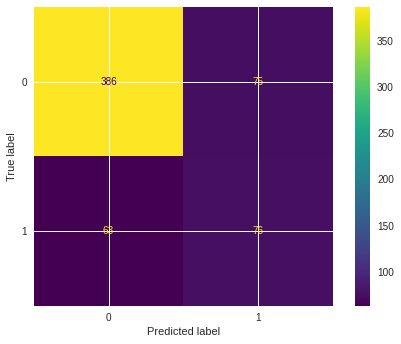

In [ ]:
ConfusionMatrixDisplay.from_predictions(Y_valid, predictionsDT)

In [ ]:
print('Precision:', precision_score(Y_valid, predictionsDT, average='micro'))
print('Recall:', recall_score(Y_valid, predictionsDT, average='micro'))
print('F1:', f1_score(Y_valid, predictionsDT, average='micro'))
print('ROC AUC:', roc_auc_score(Y_valid, predictionsDT, average='micro'))

Precision: 0.77
Recall: 0.77
F1: 0.7699999999999999
ROC AUC:  0.6920363925779117


Para este modelo se obtuvieron unos buenos resultados, aunque de todas formas debido al desbalanceo, se ve que el modelo se acostumbra a predecir negativo y por lo tanto se observa underfitting

**Random Forest**

In [ ]:
full_pipe = ColumnTransformer([
    ('cat', cat_pipe, columns_one_hot_encoder)
])
pipeline = Pipeline(steps = [
    ('col', full_pipe),
    ('rf', RandomForestClassifier())
])

parameters = {
    'rf__criterion': ['gini', 'log_loss', 'entropy'],
    'rf__class_weight': ['balanced', None],
    'rf__max_depth': [10, 15, 20, 30],
    'rf__n_estimators': [10, 50, 100, 200]
}

gridRF = GridSearchCV(pipeline,
                    param_grid = parameters,
                    scoring = ['roc_auc'],
                    refit = 'roc_auc',
                    verbose = 4,
                    n_jobs = 100,
                    cv = 3)

In [ ]:
# Iniciar el entrenamiento
gridRF.fit(X, Y)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
96 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
96 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/usr/local/lib/python3.8/dist-packages/joblib/

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('col',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['MultipleLines',
                                                                          'InternetService',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'DeviceProtection',
                                    

In [ ]:
print(f'Con una evaluación de {gridRF.best_score_}, los parámetros del mejor modelo son: \n {gridRF.best_params_}')

Con una evaluación de 0.8121803441374386, los parámetros del mejor modelo son: 
 {'rf__class_weight': 'balanced', 'rf__criterion': 'entropy', 'rf__max_depth': 10, 'rf__n_estimators': 200}


In [ ]:
predictionsRF = gridRF.predict(X_valid)

Posteriormente se evalua en el dataset de validación

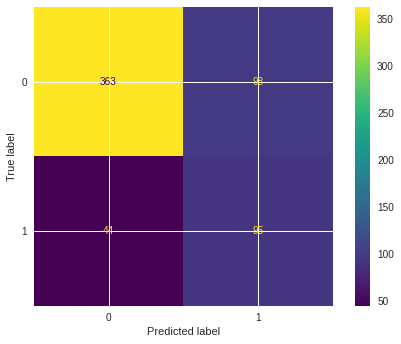

In [ ]:
ConfusionMatrixDisplay.from_predictions(Y_valid, predictionsRF)

In [ ]:
print('Precision:', precision_score(Y_valid, predictionsRF, average='micro'))
print('Recall:', recall_score(Y_valid, predictionsRF, average='micro'))
print('F1:', f1_score(Y_valid, predictionsRF, average='micro'))
print('ROC AUC: ', roc_auc_score(Y_valid, predictionsRF, average='micro'))

Precision: 0.7633333333333333
Recall: 0.7633333333333333
F1: 0.7633333333333333
ROC AUC:  0.7354359462538429


Para este modelo se obtuvieron unos mejores resultados debido a que se predijeron correctamente más clases positivas, aunque si se pueden observar tendencias al overfitting debido a que las metricas de training son mejores.

**XGBoost**

In [ ]:
pipeline = Pipeline(steps = [
    ('col', full_pipe),
    ('xgb', XGBClassifier())
])

parameters = {
    'xgb__booster': ['gbtree'],
    'xgb__learning_rate': [0.1, 0.3, 0.5, 0.7, 1],
    'xgb__max_depth': [1, 2, 3, 4, 5],
    'xgb__grow_policy': ['depthwise'],
    'xgb__n_estimators': [1, 2, 5, 10],
    'xgb__objective': ['multi:softprob', 'multi:softmax'],
    'xgb__num_class': [2]
}

'''
'scoring' es una lista con las métricas que vamos a usar como referencia para la validación cruzada que se realice.
'refit' hace referencia al score principal que se usará para definir el mejor modelo.
'cv' determina la estrategia de división de validación cruzada (Si es un entero este representa el número de folds).
'''

gridXG = GridSearchCV(pipeline,
                    param_grid = parameters,
                    scoring = ['roc_auc'],
                    refit = 'roc_auc',
                    verbose = 4,
                    n_jobs = 100,
                    cv = 3)

In [ ]:
# Iniciar el entrenamiento
gridXG.fit(X, Y)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('col',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['MultipleLines',
                                                                          'InternetService',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'DeviceProtection',
                                    

In [ ]:
predictionsXG = gridXG.predict(X_valid)

Posteriormente se evalua en el dataset de validación

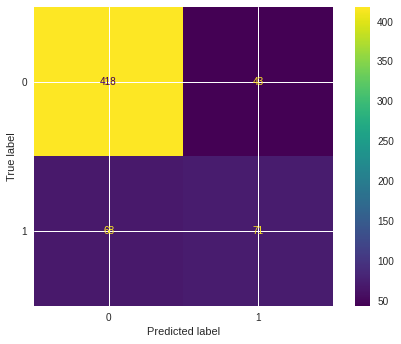

In [ ]:
ConfusionMatrixDisplay.from_predictions(Y_valid, predictionsXG)

In [ ]:
print('Precision:', precision_score(Y_valid, predictionsXG, average='micro'))
print('Recall:', recall_score(Y_valid, predictionsXG, average='micro'))
print('F1:', f1_score(Y_valid, predictionsXG, average='micro'))
print('ROC AUC: ', roc_auc_score(Y_valid, predictionsXG, average='micro'))

Precision: 0.815
Recall: 0.815
F1: 0.815
ROC AUC:  0.7087579394185303


In [ ]:
print(f'Con una evaluación de {gridXG.best_score_}, los parámetros del mejor modelo son: \n {gridXG.best_params_}')

Con una evaluación de 0.824962661509841, los parámetros del mejor modelo son: 
 {'xgb__booster': 'gbtree', 'xgb__grow_policy': 'depthwise', 'xgb__learning_rate': 0.7, 'xgb__max_depth': 2, 'xgb__n_estimators': 10, 'xgb__num_class': 2, 'xgb__objective': 'multi:softprob'}


Por ultimo para este modelo se observa que se ubtuvieron excelentes resultados en el traing pero a la hora de hacer la validación se baja un monton por lo que se puede concluir que hay overfitting y el mejor modelo es el Random Forest

In [ ]:
import joblib
best_model = gridRF.best_estimator_
joblib.dump(best_model, 'best_model.joblib')

['best_model.joblib']